# PDAN8412 PROGRAMMING PART 2- ST10065806

We'll be using the dataset from the paper "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a Kaggle Dataset.

Dataset: https://www.kaggle.com/datasets/sherinclaudia/sarcastic-comments-on-reddit

Refrences: 

Data Pre-processing, EDA and logistic Regression:
1. https://www.kaggle.com/code/yantiz/a4-demo-sarcasm-detection-with-logit#Part-2.-Training-the-model
2. https://www.kaggle.com/code/fahadmehfoooz/saracsm-eda-bidirectional-cnn-logistic-deployment/notebook#notebook-container

Logisitic Regression from scratch:
1. https://www.analyticsvidhya.com/blog/2022/02/implementing-logistic-regression-from-scratch-using-python/
2. https://towardsdatascience.com/logistic-regression-from-scratch-in-python-ec66603592e2
3. https://www.kaggle.com/code/jeppbautista/logistic-regression-from-scratch-python
4. https://www.kaggle.com/code/burhanykiyakoglu/k-nn-logistic-regression-k-fold-cv-from-scratch


## Imports

Import pandas, numpy, matplotlib, seaborn, and datetime. Then set %matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import os

%matplotlib inline

## Getting Text

It contains around 1 000 000 comments extracted from reddit . The comments have been annotated (0 = Sarcastic, 1 = Not sarcastic) and they will be used for this sentiment analysis.

**We can simply use pandas instead of manually parsing TSV in Python**

We'll use **read_csv**, to read the data in*.

In [2]:
df = pd.read_csv('data.csv')
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


## Data Pre-Processing

Some comments are missing, so we drop the corresponding rows.

In [3]:
# Data Pre-Processing
# Removing the null comments
df.dropna(subset=['comment'], inplace=True)
df['comment'] = df['comment'].str.lower()
df['comment'] = df['comment'].str.replace('[^\w\s]','')

C:\Users\User\AppData\Local\Temp/ipykernel_7428/813655304.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment'] = df['comment'].str.replace('[^\w\s]','')


In [4]:
# Converting the timestamp into DateTime object
df.created_utc = pd.to_datetime(df.created_utc)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   label           1010773 non-null  int64         
 1   comment         1010773 non-null  object        
 2   author          1010773 non-null  object        
 3   subreddit       1010773 non-null  object        
 4   score           1010773 non-null  int64         
 5   ups             1010773 non-null  int64         
 6   downs           1010773 non-null  int64         
 7   date            1010773 non-null  object        
 8   created_utc     1010773 non-null  datetime64[ns]
 9   parent_comment  1010773 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 84.8+ MB


We notice that the dataset is indeed balanced

In [5]:
df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

## Exploratory Data Analysis

Now that we cleaned the data up, Let's check out some of the stats with some plots and the built-in methods.

Text(0.5, 1.0, 'Sentiment Data Distribution')

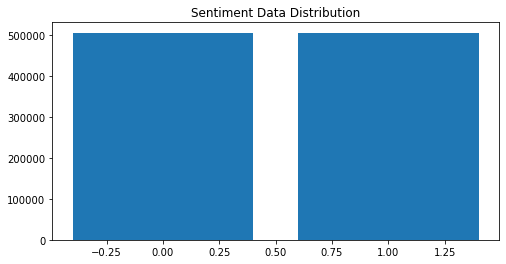

In [6]:
val_count = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

Distribution of lengths for sarcastic and normal comments is almost the same.

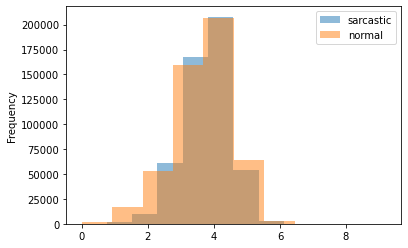

In [7]:
df.loc[df['label'] == 1, 'comment'].str.len().apply(np.log1p).plot(kind='hist', label='sarcastic', alpha=0.5)
df.loc[df['label'] == 0, 'comment'].str.len().apply(np.log1p).plot(kind='hist', label='normal', alpha=0.5)
plt.legend()

The length of the sarcastic remarks, according to the graph above, is not normally distributed, whereas the non-sarcastic comments have a minor negative skew.

### Length of Comments

Lets see if there is any relation between the length of the comment and the comment being sarcastic

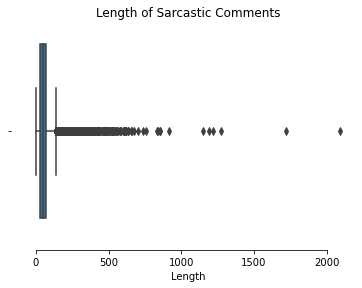

In [8]:
# Distribution of the lenth of Sarcastic comments
sns.boxplot(x= df.loc[df['label'] == 1, 'comment'].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

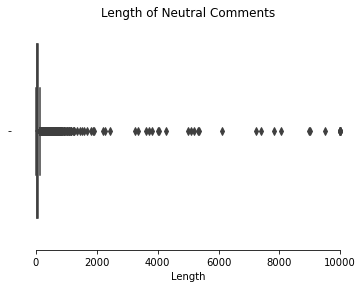

In [9]:
# Distribution of the lenth of Neutral comments
sns.boxplot(x= df.loc[df['label'] == 0, 'comment'].str.len()).set(title = 'Length of Neutral Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

We can see a skewness between Neutral comments and Sarcastic comments.

#### Portion of sarcastic comments for top 10 subreddits in the dataset

Let's analyze whether some subreddits are more "sarcastic" on average than others.

In [10]:
sub_df = df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='size', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
funny,17939,0.451474,8099
news,16891,0.603457,10193
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [11]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


The same is not particularly insightful for authors. We can see the identical amounts of sarcastic and non-sarcastic comments, with the exception of the fact that someone's comments were sampled.

#### Lets look at specific days of the week so we can try to figure out if the day of the week makes a difference

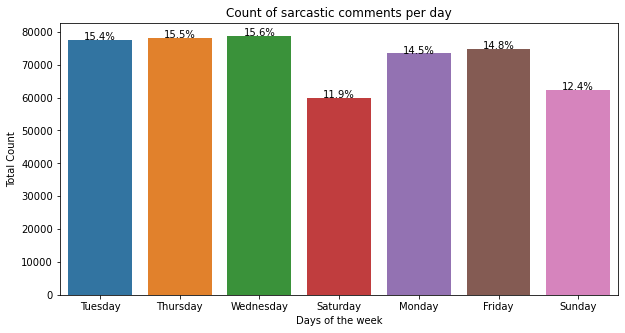

In [12]:
# Feature Engineering- Extracting the day of a week
df['created_utc'] = pd.to_datetime(df['created_utc'], format = '%d/%m/%Y %H:%M:%S')
df['Day of Week'] = df['created_utc'].dt.day_name()

# Visualization of Column- label
plt.figure(figsize=(10,5))
ax = sns.countplot(x='Day of Week',  data= df.loc[df['label']==1])
ax.set(title = "Count of sarcastic comments per day", xlabel="Days of the week", ylabel = "Total Count")
total = float(len(df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 7,
            '{:1.1f}%'.format((height/total)*100*2),
            ha="center") 
plt.show()

The aforementioned graphic demonstrates that fewer caustic remarks are made on the weekends. The fact that Reddit sees less traffic on weekends could be one factor contributing to this problem.

## Model Training using Logistic Regression

First we will use the sklearn built-in import to carry out the logistic regression and determine the accuracy of our model, so that we can compare it with Logistic Regression from scratch that we will do next. 

Imports to carry out built-in logistic regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

We split data into training and validation parts.

In [14]:
train_t, valid_t, y_train, y_valid = \
        train_test_split(df['comment'], df['label'], random_state=17)

Now lets create the logisitc regression and create a pipeline

In [15]:
# build bigrams, put a limit on maximal number of features and minimal word frequency
Vect = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

# multinomial logistic regression a.k.a softmax classifier
Model = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

# sklearn's pipeline
pipeline = Pipeline([('Vect', Vect),   ('Model', Model)])

In [16]:
pipeline.fit(train_t, y_train)

valid_pred = pipeline.predict(valid_t)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.0s finished


Checking the accuracy between the test data and the predicted data

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, valid_pred)

0.7216791851013479

## Improving the model

In [18]:
X_train, X_test = train_test_split(df, random_state=17)

In [19]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

Vect2 = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
Vect3 = TfidfVectorizer(ngram_range=(1, 1))

FU = FeatureUnion([ ('Vect2', Pipeline([('extract_field', FunctionTransformer(lambda x: x['comment'], validate=False)),
                    ('tfidf',  Vect2)])), ('Vect3', Pipeline([('extract_field',  FunctionTransformer(lambda x: x['subreddit'], 
                     validate=False)), ('tfidf', Vect3)]))])

# sklearn's pipeline
pipeline2 = Pipeline([('FU', FU), ('Model', Model)])

In [20]:
pipeline2.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.2s finished


Pipeline(steps=[('FU',
                 FeatureUnion(transformer_list=[('Vect2',
                                                 Pipeline(steps=[('extract_field',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000001159A178160>)),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_features=50000,
                                                                                  min_df=2,
                                                                                  ngram_range=(1,
                                                                                               2)))])),
                                                ('Vect3',
                                                 Pipeline(steps=[('extract_field',
                                                                  FunctionTransformer(fu

In [21]:
valid_pred = pipeline2.predict(X_test)

In [22]:
accuracy_score(y_valid, valid_pred)

0.7243939309995489

**As we can see, accuracy slightly increased**

## Confusion Matrix

A table called a confusion matrix is used to describe how well a classification system performs. The output of a classification algorithm is shown and summarised in a confusion matrix.

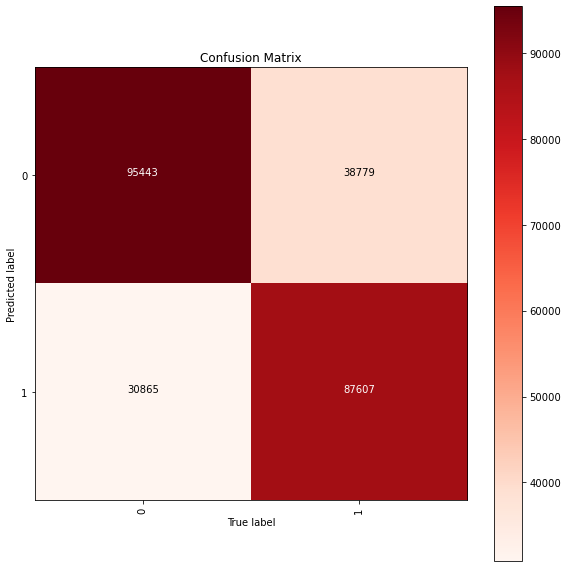

In [29]:
#This function prints and plots the confusion matrix.
#Normalization can be applied by setting `normalize=True`.

def cm(actual, predicted, classes, normalize=False, title='Confusion Matrix', figsize=(10,10), 
       cmap=plt.cm.Reds, path_to_save_fig=None):
    
    
   
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig: plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')
        
cm(y_valid, valid_pred, pipeline2.named_steps['Model'].classes_, figsize=(8, 8))

As seen above the confusion matrix confirms the accuracy of our model.

In [30]:
from sklearn.metrics import classification_report

In [31]:
print(classification_report(y_valid, valid_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73    126308
           1       0.74      0.69      0.72    126386

    accuracy                           0.72    252694
   macro avg       0.73      0.72      0.72    252694
weighted avg       0.73      0.72      0.72    252694



The report is not too bad, however as we can see the model is around 70% accurate. Meaning that 1 in 5 can be predicted inaccuratly, which to some would not be a good enogh accuracy for something like cancer prediciton or health prediciton but in terms of what we are trying to predict which is sarcasm the accuracy is good enough. 

## Logistic Regression from scratch

Down below is the code for logistic regression from scratch, however unfortunately the code is not working but can still be understood. Im sure with a few adjusments it can be working but at the point that it is at i doesnt work.

X_train = df.drop("label", axis=1).values[:int(0.8 * len(df))]

y_train = df["label"].values[:int(0.8 * len(df))]

X_test = df.drop("label", axis=1).values[int(0.8 * len(df)):]

y_test = df["label"].values[int(0.8 * len(df)):]

class StandardScaler:
    def __init__(self):
        self.u = 0
        self.s = 0
    
    def fit(self, X):
        self.u = np.mean(X, axis=0)
        self.s = np.std(X, axis=0)
    
    def transform(self, X):
        return (X - self.u) / self.s

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

class LogisticRegression:
    def __init__(self, max_iter=100, eta0=0.1):
        self.max_iter = max_iter
        self.eta0 = eta0
    
    def sigmoid(self, z):
            return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        def initialize_parameters(dim):
            w = np.zeros((dim, 1))
            b = 0
        
            return {"w": w, "b": b}
        
        def propagate():
            a = self.sigmoid(np.dot(self.parameters["w"].T, self.X) + self.parameters["b"])

            return {"dw": 1 / self.m * np.dot(self.X, (a - self.y).T),
                    "db": 1 / self.m * np.sum(a - self.y)}, \
                    -1 / self.m * (np.sum(self.y * np.log(a) + (1 - self.y) * np.log(1 - a)))

        def optimize():
            costs = []

            for i in range(self.max_iter):
                grads, cost = propagate()

                self.parameters["w"] -= self.eta0 * grads["dw"]
                self.parameters["b"] -= self.eta0 * grads["db"]

                costs.append(cost)
                
            return costs

        self.X = X.T
        self.m = self.X.shape[1]
        self.y = y.reshape(1, self.m)
        self.parameters = initialize_parameters(self.X.shape[0])
        self.costs = optimize()

    def predict(self, X):
        X = X.T
        y_pred = np.zeros((1, X.shape[1]))
        a = self.sigmoid(np.dot(self.parameters["w"].T, X) + self.parameters["b"])

        for i in range(a.shape[1]):
            y_pred[0, i] = 0 if a[0, i] <= 0.5 else 1
        
        return y_pred

log_clf = LogisticRegression(max_iter=100, eta0=1)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

accuracy_score = np.mean(y_pred == y_test)
accuracy_score